# RO-MPI validation

Should we shut off seasonal variation of noise term in equation for $\frac{dh}{dt}$? Maybe not, because it would remove seasonal predictability barrier for $h$ (note even though $\varepsilon$ has no seasonal cycle, $F_2$ *does*).

## Imports

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns
import xarray as xr
import warnings
import tqdm
import pathlib
import cmocean
import os

# Import custom modules
import src.utils
from src.XRO import XRO, xcorr
import src.XRO_utils

## set plotting specs
sns.set(rc={"axes.facecolor": "white", "axes.grid": False})

## bump up DPI
mpl.rcParams["figure.dpi"] = 100

## get filepaths
DATA_FP = pathlib.Path(os.environ["DATA_FP"])
SAVE_FP = pathlib.Path(os.environ["SAVE_FP"])

## Functions

In [2]:
def fit_RO_to_ensemble(
    model, Th_data, T_var, h_var, fit_to_members=False, **fit_kwargs
):
    """Fit RO parameters to ensemble"""

    ## fit model and generate synthetic ensemble
    if fit_to_members:

        ## fit to individual ensemble members
        kwargs = dict(model=model, T_var=T_var, h_var=h_var, verbose=True)
        _, params = src.utils.get_RO_ensemble(Th_data, **kwargs)

    else:

        ## fit to all ensemble members simultaneously
        params = model.fit_matrix(
            Th_data[[T_var, h_var]], **fit_kwargs
        )  # ac_mask_idx=ac_mask_idx, maskNT=[])

    return params


def generate_RO_ensemble(model, params, fit_to_members=False, **simulation_kwargs):
    """generate RO ensemble using given model and parameters"""

    if fit_to_members:

        RO_ensemble = src.utils.generate_ensemble(model, params, **simulation_kwargs)

    else:

        RO_ensemble = model.simulate(fit_ds=params, **simulation_kwargs)

    return RO_ensemble

## Load data

In [3]:
## MPI data
mpi_load_fp = pathlib.Path(DATA_FP, "mpi_Th", "Th.nc")
Th = xr.open_dataset(mpi_load_fp)

## Fit RO to ensemble data

In [4]:
## specify variables to use in RO fit order of annual cycle
T_var = "T_34"
h_var = "h"
ac_order = 3

## specify whether to fit parameters to each ens. member individually
## if False, fit single set of parameters to all ensemble members
fit_to_members = False


### specify fit kwargs
## ac_mask_idx: which indices to mask annual cycle out for.
## maskNT: which nonlinear terms to include for dT/dt
fit_kwargs = dict(ac_mask_idx=[(1, 1)], maskNT=[])

## get data for early/late period
Th_early = Th.isel(time=slice(None, 588))
Th_late = Th.isel(time=slice(-588, None))

## specify model to use
model = XRO(ncycle=12, ac_order=ac_order, is_forward=True)

## fit models to early/late periods
RO_params_early = fit_RO_to_ensemble(
    model,
    Th_data=Th_early,
    T_var=T_var,
    h_var=h_var,
    fit_to_members=False,
    **fit_kwargs
)
RO_params_late = fit_RO_to_ensemble(
    model, Th_data=Th_late, T_var=T_var, h_var=h_var, fit_to_members=False, **fit_kwargs
)

/Users/theo/research/enso2025_xro/envs/lib/python3.13/site-packages/xarray/computation/apply_ufunc.py:821: RuntimeWarning: invalid value encountered in power
  result_data = func(*input_data)
/Users/theo/research/enso2025_xro/envs/lib/python3.13/site-packages/xarray/computation/apply_ufunc.py:821: RuntimeWarning: invalid value encountered in power
  result_data = func(*input_data)
/Users/theo/research/enso2025_xro/envs/lib/python3.13/site-packages/xarray/computation/apply_ufunc.py:821: RuntimeWarning: invalid value encountered in power
  result_data = func(*input_data)
/Users/theo/research/enso2025_xro/envs/lib/python3.13/site-packages/xarray/computation/apply_ufunc.py:821: RuntimeWarning: invalid value encountered in power
  result_data = func(*input_data)


## Get ensemble of RO simulations

In [5]:
## specify arguments for simulation
simulation_kwargs = dict(
    nyear=49, ncopy=1000, seed=1000, X0_ds=Th[[T_var, h_var]].isel(member=0, time=0)
)

## perform simulations
RO_ensemble_early = generate_RO_ensemble(
    model, RO_params_early, fit_to_members=fit_to_members, **simulation_kwargs
)
RO_ensemble_late = generate_RO_ensemble(
    model, RO_params_late, fit_to_members=fit_to_members, **simulation_kwargs
)

## filter outsimulations which blow up
# bad_sim = (RO_ensemble[T_var] > 5).any("time")
# RO_ensemble = RO_ensemble.isel(member=~bad_sim)

## Diagnostics

### Seasonality

In [6]:
def format_axs(axs):
    """add formatting to paneled subplot of seasonal cycle"""

    axs[0].set_yticks([0.5, 1])
    axs[0].set_ylabel(r"$^{\circ}$C")
    axs[0].set_title(r"1850-1889")
    axs[1].set_title(r"2051-2100")
    axs[2].set_title(r"Early vs. Late (MPI)")
    axs[2].set_yticks([0.5, 1])
    axs[2].yaxis.set_ticks_position("right")
    axs[0].legend(prop=dict(size=8))
    axs[1].legend(prop=dict(size=8))
    axs[2].legend(prop=dict(size=8))
    return

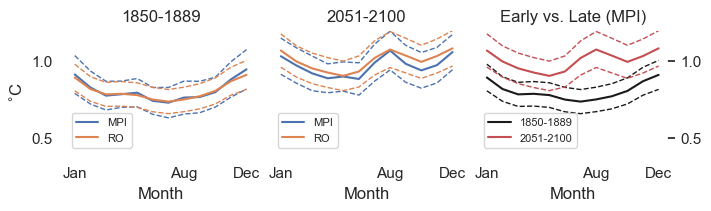

In [7]:
### Set up plot
fig, axs = plt.subplots(1, 3, figsize=(7, 2), layout="constrained")

## plot MPI vs. RO (early period)
plot_data_early = src.utils.plot_seasonal_comp(
    axs[0],
    x0=Th_early,
    x1=RO_ensemble_early,
    plot_kwargs0=dict(label="MPI"),
    plot_kwargs1=dict(label="RO"),
    varname=T_var,
)

## Plot MPI vs RO (late period)
plot_data_late = src.utils.plot_seasonal_comp(
    axs[1],
    x0=Th_late,
    x1=RO_ensemble_late,
    plot_kwargs0=dict(label="MPI"),
    plot_kwargs1=dict(label="RO"),
    varname=T_var,
)

## Plot early vs late (MPI)
plot_data_delta = src.utils.plot_seasonal_comp(
    axs[2],
    x0=RO_ensemble_early,
    x1=RO_ensemble_late,
    plot_kwargs0=dict(label="1850-1889", c="k"),
    plot_kwargs1=dict(label="2051-2100", c="r"),
    varname=T_var,
)

## label plot
format_axs(axs)

plt.show()

### $T$, $h$ cross-correlation

Plotting functions

In [8]:
def format_axs(axs):
    """make axes nice for plot"""

    for ax in axs[1, :]:
        ax.set_xticks([-12, 0, 12], labels=[-1, 0, 1])
        ax.set_xlabel("Lag (years)")
    for ax in axs[:, 0]:
        ax.set_yticks([0, 0.5, 1])
    axs[0, 0].set_title(r"1850-1889")
    axs[0, 1].set_title(r"2051-2100")
    axs[0, 2].set_title(r"Early vs. Late (MPI)")
    axs[0, 0].set_ylabel(r"Corr$(T,T)$ ")
    axs[1, 0].set_ylabel(r"Corr$(T,h)$ ")
    return


def plot_xcorr(ax, data, **plot_kwargs):
    """plot mean and bounds for data"""

    ## center
    plot_data = ax.plot(data.lag, data.sel(posn="center"), **plot_kwargs)

    ## bounds
    ax.fill_between(
        data.lag,
        data.sel(posn="upper"),
        data.sel(posn="lower"),
        color=plot_data[0].get_color(),
        alpha=0.2,
    )

    ## set axis specs
    ax.set_ylim([-0.5, 1.05])
    ax.set_xlim([-18, 18])
    ax.set_xticks([])
    ax.set_yticks([])
    axis_kwargs = dict(c="k", lw=0.5, alpha=0.5)
    ax.axhline(0, **axis_kwargs)
    ax.axvline(0, **axis_kwargs)

    return


def plot_xcorr2(axs, xcorr_eval, T_var="T_34", h_var="h", **plot_kwargs):
    """plot <T,T> and <h,T> correlation on set of axs"""

    ## compute cross correlation and get ensemble stats
    xcorr_stats = src.utils.get_ensemble_stats(xcorr_eval)

    ## plot autocorrelation/cross correlation on separate axes
    plot_xcorr(axs[0], xcorr_stats[T_var], **plot_kwargs)
    plot_xcorr(axs[1], xcorr_stats[h_var], **plot_kwargs)

    return

Compute cross-correlation stats

In [9]:
## specify T variable to use
T_var = "T_34"

## function to compute cross-corr
get_xcorr = lambda x: xcorr(x, x[T_var], maxlags=18)

## compute
xcorr_Th_early = get_xcorr(Th_early)
xcorr_Th_late = get_xcorr(Th_late)
xcorr_RO_early = get_xcorr(RO_ensemble_early)
xcorr_RO_late = get_xcorr(RO_ensemble_late)

Make plot

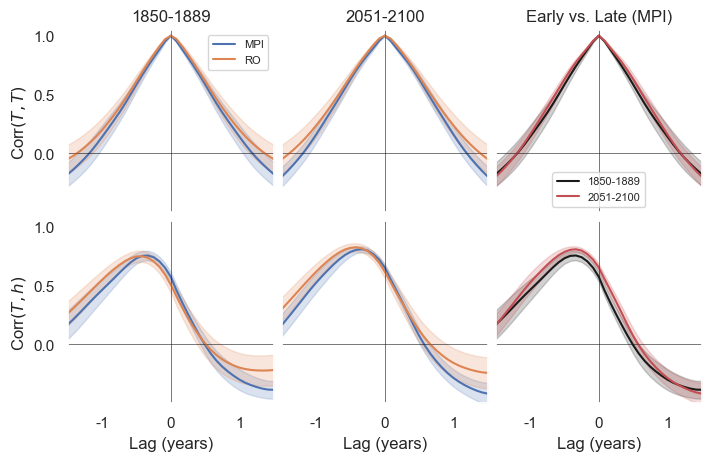

In [10]:
fig, axs = plt.subplots(2, 3, figsize=(7, 4.5), layout="constrained")

plot_xcorr2(axs[:, 0], xcorr_Th_early, label="MPI")
plot_xcorr2(axs[:, 0], xcorr_RO_early, label="RO")

plot_xcorr2(axs[:, 1], xcorr_Th_late)
plot_xcorr2(axs[:, 1], xcorr_RO_late)

plot_xcorr2(axs[:, 2], xcorr_Th_early, c="k", label="1850-1889")
plot_xcorr2(axs[:, 2], xcorr_Th_late, c="r", label="2051-2100")

## label axes
format_axs(axs)
axs[0, 0].legend(prop=dict(size=8))
axs[0, 2].legend(prop=dict(size=8))

plt.show()

### Power spectrum

Plotting functions

Compute PSD

In [12]:
## specify which variable to use
varname = "T_34"

## specify args for psd
psd_kwargs = dict(dim="time", dt=1 / 12, nw=5)

## compute PSD
compute_psd = lambda x: src.XRO_utils.pmtm(x[varname], **psd_kwargs)
psd_mpi_early = compute_psd(Th_early)
psd_RO_early = compute_psd(RO_ensemble_early)
psd_mpi_late = compute_psd(Th_late)
psd_RO_late = compute_psd(RO_ensemble_late)

Plot PSD

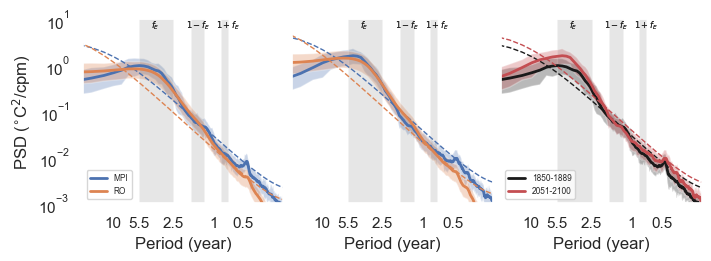

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(7, 2.5), layout="constrained")

## plot early
src.utils.plot_psd(axs[0], psd_mpi_early, label="MPI")
src.utils.plot_psd(axs[0], psd_RO_early, label="RO")

# ## plot late
src.utils.plot_psd(axs[1], psd_mpi_late, label="MPI")
src.utils.plot_psd(axs[1], psd_RO_late, label="RO")

# ## plot late
src.utils.plot_psd(axs[2], psd_mpi_early, label="1850-1889", color="k")
src.utils.plot_psd(axs[2], psd_mpi_late, label="2051-2100", color="r")


## label
axs[0].set_ylabel(r"PSD ($^{\circ}$C$^2$/cpm)")
axs[0].legend(prop=dict(size=6))
axs[2].legend(prop=dict(size=6))
for ax in axs[1:]:
    ax.set_yticks([])


plt.show()